# Acurate analysis of results for RNN models

In [1]:
import numpy as np
import os

import itertools

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import pandas as pd
from keras.models import load_model
from keras.utils import to_categorical

# Import own methods

import data_generator as dg
import ml_utils as mlu

Using TensorFlow backend.


## Data

In [2]:
dataTrWinValues, dataTrWinLabel, dataTestWinValues, dataTestWinLabel, dataWinOrganization = \
dg.loadDataSetInBlocks('../', nTestUsers=8, windowSize=256, stride=128)

## Auxilliary parameters to load the model. It's necessary because the model uses a custom weighted loss function

unique, counts = np.unique(dataTrWinLabel, return_counts=True)

dict_counts = dict(zip(unique,counts))
print(dict_counts)

N_bkg = dict_counts[0]
N_alert = dict_counts[1]
N_fall = dict_counts[2]

print(N_bkg, N_alert, N_fall)

w_bkg = 1
w_alert = N_bkg / N_alert 
w_fall = N_bkg / N_fall

target_weights = [w_bkg,w_alert,w_fall]
print(target_weights)

# The loss function implemented doesn't work with int targets
from keras.utils import to_categorical

dataTrWinLabelOneHot = to_categorical(dataTrWinLabel)
dataTestWinLabelOneHot = to_categorical(dataTestWinLabel)


Loading data...

Divided (train - test) found. Loading...

Data loaded correctly

Estructuring data in blocks...

Data generated correctly
{0: 89631, 1: 1031, 2: 3380}
89631 1031 3380
[1, 86.93598448108632, 26.518047337278105]


## Loading model and results (summary stored)

In [3]:
# Model name parameter to load the specific one

research_set_folder = 'researchset4'
file_id_name = 'model_id_2'


### Model table

In [4]:
research_set_table = pd.read_csv(research_set_folder + '/' + research_set_folder + '_research_summary.csv')
research_set_table

,model_id,w,stride,rnn_type,lr,batch_size,rnn_dropout,dense_dropout,two_rnn_layers,first_dense
0,1,256,128,lstm,0.001,32,0.20,0.2,False,False
1,2,256,128,lstm,0.001,32,0.35,0.0,False,False
2,3,256,128,lstm,0.001,32,0.35,0.2,False,False
3,4,256,128,lstm,0.001,64,0.20,0.2,False,False
4,5,256,128,lstm,0.001,64,0.35,0.0,False,False
5,6,256,128,lstm,0.001,64,0.35,0.2,False,False
6,7,256,128,gru,0.001,32,0.20,0.2,False,False
7,8,256,128,gru,0.001,32,0.35,0.0,False,False
8,9,256,128,gru,0.001,32,0.35,0.2,False,False
9,10,256,128,gru,0.001,64,0.20,0.2,False,False


### Independent model results

#### Show results

In [6]:
ex_model_info = np.load(research_set_folder + '/' + research_set_folder +  '_' + file_id_name+ '_info.npy')
ex_model_info = ex_model_info[()]
ex_model_info['optional_data']

'n_test_subjects=8, w=256, stride=128'

* #### Train history

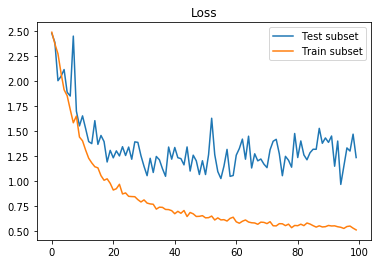

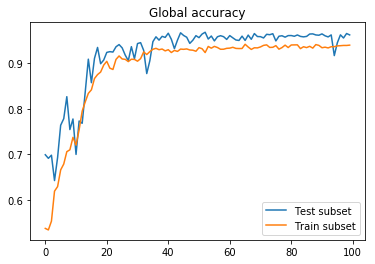

In [7]:
train_history = ex_model_info['train_history']
plt.close("all")
plt.plot(list(range(len(train_history['val_loss']))), train_history['val_loss'], label = 'Test subset')
plt.plot(list(range(len(train_history['loss']))), train_history['loss'], label = 'Train subset' )
plt.title("Loss")
plt.legend()

plt.show()

plt.plot(list(range(len(train_history['val_acc']))), train_history['val_acc'], label = 'Test subset')
plt.plot(list(range(len(train_history['acc']))), train_history['acc'], label = 'Train subset' )
plt.title("Global accuracy")
plt.legend()

plt.show()

* #### Evaluation with test set

Normalized confusion matrix
[[0.97 0.03 0.01]
 [0.2  0.76 0.05]
 [0.01 0.05 0.93]]
Confusion matrix, without normalization
[[21212   610   145]
 [   67   259    16]
 [    9    35   593]]


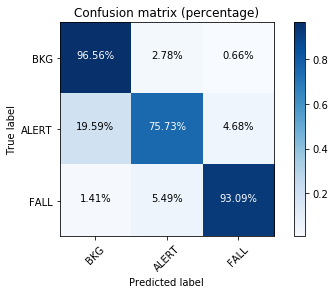

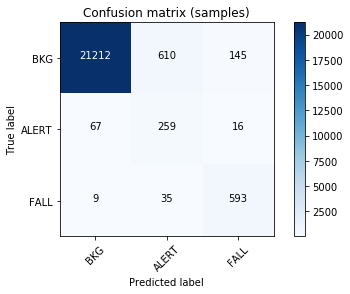

In [8]:
eval_results = ex_model_info['eval_results']
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix_v2(eval_results, classes=['BKG', 'ALERT', 'FALL'], normalize=True,
                      title='Confusion matrix (percentage)')

# Plot non-normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix_v2(eval_results, classes=['BKG', 'ALERT', 'FALL'],
                      title='Confusion matrix (samples)')

plt.show()

## Analysis in retrospect

### Loading Model

In [9]:
model = load_model(research_set_folder + '/' + research_set_folder + '_' + file_id_name + '_fullmodel.h5', custom_objects={'loss': mlu.weighted_categorical_crossentropy(target_weights)})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 256, 3)            12        
_________________________________________________________________
dropout_3 (Dropout)          (None, 256, 3)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 32)                4736      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 4,847
Trainable params: 4,841
Non-trainable params: 6
_________________________________________________________________


In [10]:
model_prediction = model.predict(dataTestWinValues[:,:,:3])

In [55]:
def plot_accel_with_predictions(block_accel_data, block_labels, block_predictions, real_clasif, block_index_init, block_index_end, stride_ind=0.5):
    
    colors = ['g', 'y', 'r'] # bkg, alert, fall
    
    span_colors = ['g', 'y', 'r', 'g'] # real regions 
    
    width = len(block_accel_data[0])
    stride = int(width*stride_ind)
    
    n_of_charts = round(stride_ind**-1)
    
    charts = [[[],[]] for i in range(n_of_charts)] # each chart contains the list of corresponding blocks and the list of respective predictions

    for i in range(block_index_end-block_index_init):
        index_sample = i+block_index_init
        charts[i%n_of_charts][0].append(block_accel_data[index_sample])
        charts[i%n_of_charts][1].append(block_predictions[index_sample])
    
    subplotings = [plt.subplots() for n in range(n_of_charts)]
    
    real_clasif_inits = [i for i in range(1,len(real_clasif)) if real_clasif[i] != real_clasif[i-1]]
    print(real_clasif_inits)
    for ch_i in range(n_of_charts):
        print(len(charts[ch_i][0]))
        x_init_range_ls = list()
        for sample_j in range(len(charts[ch_i][0])):
            
            x_init_range = ch_i*stride + sample_j*width;
            x_init_range_ls.append(x_init_range)
            """
            print(x_init_range)
            print(width)
            print(stride)
            print(len(list(range(x_init_range, x_init_range + width))))
            print(np.shape(charts[ch_i][0][sample_j][:,0]))
            """
            try:
                subplotings[ch_i][1].plot(
                    list(range(x_init_range, x_init_range + width)), charts[ch_i][0][sample_j][:,0],
                    list(range(x_init_range, x_init_range + width)), charts[ch_i][0][sample_j][:,1],
                    list(range(x_init_range, x_init_range + width)), charts[ch_i][0][sample_j][:,2],
                    color=colors[charts[ch_i][1][sample_j]], linewidth=0.2)
                subplotings[ch_i][1].set_title("Reconstruction with stride {}".format(ch_i*stride))
                
            except:
                print('ch_i: {}, sample_j: {}'.format(ch_i, sample_j))
        
        
        subplotings[ch_i][1].vlines(x_init_range_ls, -1000, 1000, transform=subplotings[ch_i][1].get_xaxis_transform(), colors='b', lw=0.5, linestyles='dotted')
        # subplotings[ch_i][1].vlines(ind, -1000, 1000, transform=subplotings[ch_i][1].get_xaxis_transform(), colors='m', lw=0.5, linestyles='dashed')

        """init = 0 #ch_i*stride
        for ind in range(len(real_clasif_inits)): #+ ch_i*stride
            subplotings[ch_i][1].axvspan(init, real_clasif_inits[ind], facecolor=span_colors[ind], alpha=0.1)
            init = real_clasif_inits[ind] # + ch_i*stride
        subplotings[ch_i][1].axvspan(init, len(charts[ch_i][0]*256), facecolor=span_colors[-1], alpha=0.1)
        subplotings[ch_i][1].set_xlim(left=0, right=len(real_clasif))
        """
        plt.figure()        

    plt.show()
    

In [18]:
np.shape(dataWinOrganization['test'])
activities_name_and_init_index = [(dataWinOrganization['test'][i],i)  for i in range(len(dataWinOrganization['test'])) if i == 0 or dataWinOrganization['test'][i] != dataWinOrganization['test'][i-1]]

activity_names, block_indexes_init = zip(*activities_name_and_init_index)
activity_and_init_and_list_index = list(zip(activities_name_and_init_index, list(range(len(activities_name_and_init_index)))))
activity_and_init_and_list_index

[((('SA04', 'D01', 'R01'), 0), 0),
 ((('SA04', 'D02', 'R01'), 155), 1),
 ((('SA04', 'D03', 'R01'), 310), 2),
 ((('SA04', 'D04', 'R01'), 465), 3),
 ((('SA04', 'D05', 'R01'), 620), 4),
 ((('SA04', 'D05', 'R02'), 658), 5),
 ((('SA04', 'D05', 'R03'), 696), 6),
 ((('SA04', 'D05', 'R04'), 734), 7),
 ((('SA04', 'D05', 'R05'), 772), 8),
 ((('SA04', 'D06', 'R01'), 810), 9),
 ((('SA04', 'D06', 'R02'), 848), 10),
 ((('SA04', 'D06', 'R03'), 886), 11),
 ((('SA04', 'D06', 'R04'), 924), 12),
 ((('SA04', 'D06', 'R05'), 962), 13),
 ((('SA04', 'D07', 'R01'), 1000), 14),
 ((('SA04', 'D07', 'R02'), 1017), 15),
 ((('SA04', 'D07', 'R03'), 1034), 16),
 ((('SA04', 'D07', 'R04'), 1051), 17),
 ((('SA04', 'D07', 'R05'), 1068), 18),
 ((('SA04', 'D08', 'R01'), 1085), 19),
 ((('SA04', 'D08', 'R02'), 1102), 20),
 ((('SA04', 'D08', 'R03'), 1119), 21),
 ((('SA04', 'D08', 'R04'), 1136), 22),
 ((('SA04', 'D08', 'R05'), 1153), 23),
 ((('SA04', 'D09', 'R01'), 1170), 24),
 ((('SA04', 'D09', 'R02'), 1187), 25),
 ((('SA04', 

In [166]:
dataWinOrganization['test'][620]

22946

In [54]:
dataWinOrganization['test'][155]

('SA04', 'D02', 'R01')

In [19]:
predictions = np.argmax(model_prediction, axis=1)

In [13]:
trainData, trainClasif, testData, testClasif, dataOrganization = dg.prepareDataSetForTrain('../', nTestUsers=8)
print('Done!')

#print(dataOrganization)


Divided (train - test) found. Loading...
Done!


[1324, 1385, 1433]
11
11


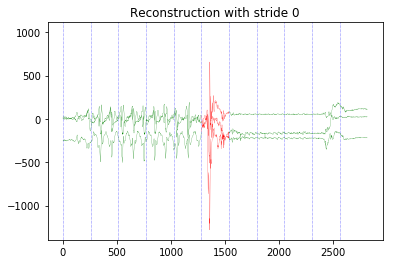

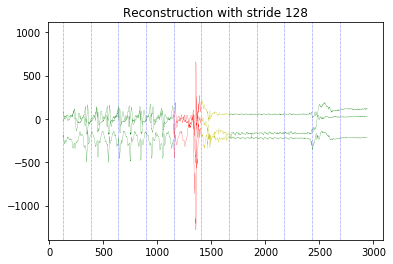

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [56]:
plot_accel_with_predictions(dataTestWinValues[:,:,:3], predictions, testClasif[233], block_indexes_init[233], block_indexes_init[234], stride_ind=0.5)

In [58]:
#plt.plot(range(len(testClasif[234])), testData[234][:,0], range(len(testClasif[234])), testData[234][:,1], range(len(testClasif[234])), testData[234][:,2],color='g', linewidth=0.2)
#plt.show()

In [57]:
#testClasif[262][1300:1500]